In [ ]:
%load_ext autoreload

In [11]:
%autoreload 2

import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import matplotlib.pyplot as plt
from utils.utils import show_images
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
from torchvision.transforms import transforms
from tqdm import tqdm
from typing import Optional
import numpy as np
from torch import nn
from src.mod.datasets.utils import create_latent_vectors
from src.mod.plugins.early_stopping import EarlyStopping
from src.mod.datasets import CelebA
from src.mod.models import Classifier, Generator, Discriminator
from src.mod.datasets.utils import split_dataset

In [12]:
latent_vector_size = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
from torch.utils.tensorboard import SummaryWriter

transform = transforms.Compose([
  transforms.RandomResizedCrop(64),
  transforms.RandomHorizontalFlip(),
  transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
  transforms.RandomRotation(degrees=(0, 5)),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = CelebA(
  dataset_path='../resources/datasets/celeba',
  image_directory='images',
  annotations_directory='annotations',
  image_transform=transform
)

generator = Generator(latent_vector_size, 64, 3, with_init=True)
discriminator = Discriminator(3, 64, with_init=True)
classifier = Classifier((3, 64, 64), 40, with_init=True)

writer = SummaryWriter("../resources/logs")

In [15]:
generator

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [16]:
discriminator

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [17]:
classifier

Classifier(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=8192, out_features=512, bias=True)
    (11): ReLU(inplace=True)
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=512, out_features=3, bias=True)
    (14): Sigmoid()
  )
)

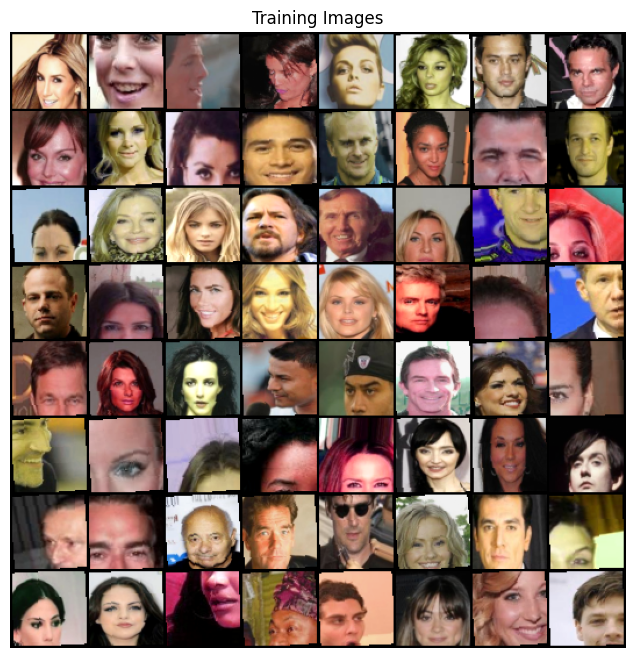

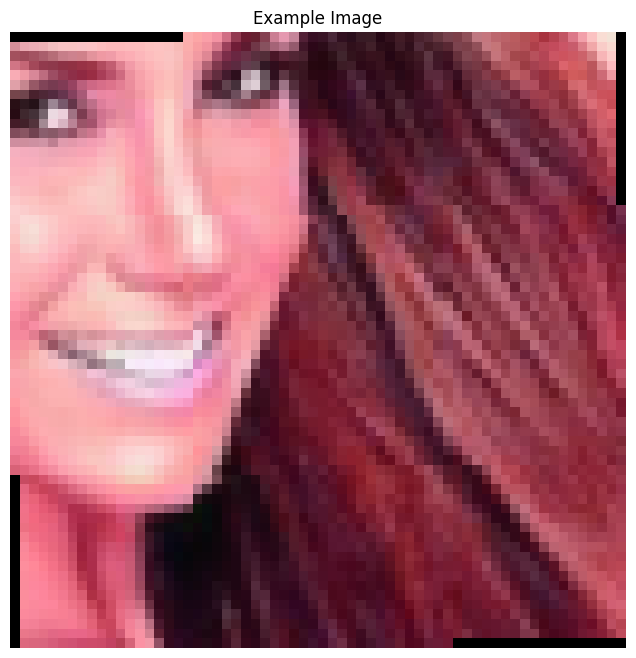

 1:  No - 5_o_Clock_Shadow
 2: Yes - Arched_Eyebrows
 3: Yes - Attractive
 4:  No - Bags_Under_Eyes
 5:  No - Bald
 6:  No - Bangs
 7:  No - Big_Lips
 8:  No - Big_Nose
 9:  No - Black_Hair
10:  No - Blond_Hair
11:  No - Blurry
12: Yes - Brown_Hair
13:  No - Bushy_Eyebrows
14:  No - Chubby
15:  No - Double_Chin
16:  No - Eyeglasses
17:  No - Goatee
18:  No - Gray_Hair
19: Yes - Heavy_Makeup
20: Yes - High_Cheekbones
21:  No - Male
22: Yes - Mouth_Slightly_Open
23:  No - Mustache
24:  No - Narrow_Eyes
25: Yes - No_Beard
26:  No - Oval_Face
27:  No - Pale_Skin
28: Yes - Pointy_Nose
29:  No - Receding_Hairline
30:  No - Rosy_Cheeks
31:  No - Sideburns
32: Yes - Smiling
33: Yes - Straight_Hair
34:  No - Wavy_Hair
35: Yes - Wearing_Earrings
36:  No - Wearing_Hat
37: Yes - Wearing_Lipstick
38:  No - Wearing_Necklace
39:  No - Wearing_Necktie
40: Yes - Young


In [18]:
def show_examples():
  dataloader = DataLoader(dataset, batch_size=64, num_workers=2)
  (images, _, _) = next(iter(dataloader))

  plt.figure(figsize=(8, 8))
  plt.axis("off")
  plt.title("Training Images")
  show_images(images)


def show_annotated_example():
  dataloader = DataLoader(dataset, batch_size=1, num_workers=2)
  (images, annotations, _) = next(iter(dataloader))
  annotations = annotations[0][0]

  plt.figure(figsize=(8, 8))
  plt.axis("off")
  plt.title("Example Image")
  show_images(images)
  for (i, column) in enumerate(dataset.annotations.columns):
    print(f"{i + 1:>2}: {annotations[i] > 0.9 and 'Yes' or 'No':>3} - {column}")


show_examples()
show_annotated_example()

Training Process:
1. GAN Training:
- Train D to differentiate real images from those generated by G.
- Train G to fool D into classifying its outputs as real images.
2. Classifier Training:
- Train C using real images and their trait annotations.
3. Combined Training:
- Train G to not only fool D but also to generate images that C classifies with specified traits.

In [19]:

def train_gan(
    generator: nn.Module,
    discriminator: nn.Module,
    dataloader: DataLoader,
    *,
    epoch_count: int,
    save_to: Optional[str] = None,
    device: torch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
):
  generator.train()
  discriminator.train()
  generator.to(device)
  discriminator.to(device)

  RealLabel = 1.0
  FakeLabel = 0.0

  lr = 0.001
  beta1 = 0.9

  discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
  discriminator_scheduler = ReduceLROnPlateau(discriminator_optimizer, 'min', patience=20, factor=0.5)
  generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
  generator_scheduler = ReduceLROnPlateau(generator_optimizer, 'min', patience=20, factor=0.5)

  generator_criterion = nn.BCELoss()
  discriminator_criterion = nn.BCELoss()
  fixed_noise = create_latent_vectors(64, latent_vector_size, device)

  iterations = 0
  for epoch in tqdm(range(epoch_count), desc="Epochs", total=epoch_count):
    for batch_nr, (images, _, _) in tqdm(enumerate(dataloader), desc="Batches", total=len(dataloader)):
      discriminator.zero_grad()
      real_images = images.to(device)
      batch_size = real_images.size(0)

      real_labeling = torch.full((batch_size,), RealLabel, dtype=torch.float, device=device)
      expected_labeling = discriminator(real_images).view(-1)
      real_images_discriminator_loss = discriminator_criterion(expected_labeling, real_labeling)
      real_images_discriminator_loss.backward()

      latent_vectors = create_latent_vectors(batch_size, latent_vector_size, device)
      fake_images = generator(latent_vectors)
      real_labeling.fill_(FakeLabel)
      expected_labeling = discriminator(fake_images.detach()).view(-1)

      fake_images_discriminator_loss = discriminator_criterion(expected_labeling, real_labeling)
      fake_images_discriminator_loss.backward()

      discriminator_loss = real_images_discriminator_loss + fake_images_discriminator_loss
      discriminator_scheduler.step(discriminator_loss)

      generator.zero_grad()
      real_labeling.fill_(RealLabel)
      expected_labeling = discriminator(fake_images).view(-1)
      generator_loss = generator_criterion(expected_labeling, real_labeling)
      generator_loss.backward()
      generator_scheduler.step(generator_loss)

      dloss = discriminator_loss.item()
      gloss = generator_loss.item()
      writer.add_scalar("[DG] - Discriminator Loss", dloss, iterations)
      writer.add_scalar("[DG] - Generator Loss", gloss, iterations)

      if (iterations % 500 == 0) or (
          ((epoch % 5 == 0) or (epoch == epoch_count)) and (batch_nr == len(dataloader) - 1)):
        with torch.no_grad(): fake_images = generator(fixed_noise).detach().cpu()
        writer.add_images("[DG] Generated Images", fake_images, iterations)

      iterations += 1
  generator.eval()
  discriminator.eval()

  if save_to:
    torch.save(generator.state_dict(), f"g.{save_to}")
    torch.save(discriminator.state_dict(), f"d.{save_to}")

  return generator, discriminator


dataloader = DataLoader(dataset, batch_size=64, num_workers=8)
train_gan(
  generator,
  discriminator,
  dataloader,
  epoch_count=20,
  save_to="metrics.pt"
)

Batches:   0%|          | 0/3166 [00:00<?, ?it/s]/home/teba_dzdancewicz/PycharmProjects/2023-dl/venv/lib64/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,

Epochs:   0%|          | 0/20 [00:46<?, ?it/s]


KeyboardInterrupt: 

2. Classifier Training:
- Train C using real images and their trait annotations.
3. Combined Training:
- Train G to not only fool D but also to generate images that C classifies with specified traits.

In [22]:
def train_classifier(
    classifier: nn.Module,
    train_dataloader: DataLoader,
    validation_dataloader: DataLoader,
    *,
    epoch_count: int,
    save_to: Optional[str] = None,
    device: torch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
):
  classifier.train()
  classifier.to(device)

  lr = 0.001
  beta1 = 0.9
  optimizer = optim.Adam(classifier.parameters(), lr=lr, betas=(beta1, 0.999))
  scheduler = ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
  criterion = nn.BCELoss()
  early_stopping = EarlyStopping(classifier, patience=10, verbose=True, save_to=save_to)

  for epoch in tqdm(range(1, epoch_count + 1), desc="Epochs", total=epoch_count):
    classifier.train()
    train_loss = 0.0
    for images, annotations, _ in tqdm(
        train_dataloader,
        desc="Traning",
        total=len(train_dataloader)
    ):
      classifier.zero_grad()
      real_images = images.to(device)
      annotations = annotations.to(device)
      expected_annotations = classifier(real_images).unsqueeze(1)

      real_images_loss = criterion(expected_annotations, annotations)
      real_images_loss.backward()

      optimizer.step()
      scheduler.step(real_images_loss)

      train_loss += real_images_loss.item()
    train_loss /= len(train_dataloader)

    classifier.eval()
    val_loss = 0.0
    for images, annotations, _ in tqdm(
        validation_dataloader,
        desc="Validation",
        total=len(validation_dataloader)
    ):
      classifier.zero_grad()
      real_images = images.to(device)
      annotations = annotations.to(device)
      expected_annotations = classifier(real_images).unsqueeze(1)
      real_images_loss = criterion(expected_annotations, annotations)
      val_loss += real_images_loss.item()
      optimizer.step()
      scheduler.step(real_images_loss)

    val_loss /= len(validation_dataloader)

    writer.add_scalar("[C] - Train Loss", train_loss, epoch)
    writer.add_scalar("[C] - Validation Loss", val_loss, epoch)
    if early_stopping.step(val_loss): break

  classifier.load_state_dict(save_to)

  return classifier


def initialize_weights(layer: nn.Module):
  if isinstance(layer, nn.Linear):
    nn.init.xavier_uniform_(layer.weight.data)
    if layer.bias is not None:
      nn.init.constant_(layer.bias.data, 0)


train_dataloader, validation_dataloader = split_dataset(dataset, 0.8)

train_classifier(
  classifier,
  train_dataloader,
  validation_dataloader,
  epoch_count=20,
  save_to="metrics.pt"
)


Epochs:   0%|          | 0/20 [00:26<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
def show_real_image_and_predicted_attributes(classifier, dataset, index):
  (image, attributes, _) = dataset[index]
  image = image.unsqueeze(0)
  attributes = attributes.unsqueeze(0).numpy()
  classified = classifier(image).cpu().detach().numpy()
  errors = np.abs(classified - attributes)

  attributes = attributes[0][0]
  classified = classified[0]
  errors = errors[0][0]

  plt.figure(figsize=(8, 8))
  plt.axis("off")
  plt.title("Example Image")
  show_images(image)
  for i, (attribute, classification, error, label) in enumerate(
      zip(attributes, classified, errors, dataset.annotations.columns)
  ):
    print(f"{i:>2}: {attribute > 0.9 and 'Yes' or 'No':>3} - C{classification:.2f} - E{error:.2f} - {label}")


show_real_image_and_predicted_attributes(classifier, dataset, 1)


3. Combined Training:
- Train G to not only fool D but also to generate images that C classifies with specified traits.

In [23]:
def train_gan_and_classifier_at_the_same_time(
    generator: nn.Module,
    discriminator: nn.Module,
    classifier: nn.Module,
    dataloader: DataLoader,
    *,
    epoch_count: int,
    save_to: Optional[str] = None,
    device: torch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
):
  generator.train()
  discriminator.train()
  classifier.train()
  generator.to(device)
  discriminator.to(device)
  classifier.to(device)

  RealLabel = 1.0
  FakeLabel = 0.0

  lr = 0.001
  beta1 = 0.9

  discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
  discriminator_scheduler = ReduceLROnPlateau(discriminator_optimizer, 'min', patience=20, factor=0.5)
  generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
  generator_scheduler = ReduceLROnPlateau(generator_optimizer, 'min', patience=20, factor=0.5)
  classifier_optimizer = optim.Adam(classifier.parameters(), lr=lr, betas=(beta1, 0.999))
  classifier_scheduler = ReduceLROnPlateau(classifier_optimizer, 'min', patience=20, factor=0.5)

  generator_criterion = nn.BCELoss()
  discriminator_criterion = nn.BCELoss()
  classifier_criterion = nn.BCELoss()
  fixed_noise = create_latent_vectors(64, latent_vector_size, device)

  iterations = 0
  for epoch in tqdm(range(epoch_count), desc="Epochs", total=epoch_count):
    for batch_nr, (images, annotations, _) in tqdm(enumerate(dataloader), desc="Batches", total=len(dataloader)):
      real_images = images.to(device)
      annotations = annotations.to(device)

      batch_size = real_images.size(0)
      real_labeling = torch.full((batch_size,), RealLabel, dtype=torch.float, device=device)

      discriminator.zero_grad()
      expected_labeling = discriminator(real_images).view(-1)
      real_images_discriminator_loss = discriminator_criterion(expected_labeling, real_labeling)
      real_images_discriminator_loss.backward()

      latent_vectors = create_latent_vectors(batch_size, latent_vector_size, device)
      fake_images = generator(latent_vectors).detach()
      real_labeling.fill_(FakeLabel)
      expected_labeling = discriminator(fake_images).view(-1)
      fake_images_discriminator_loss = discriminator_criterion(expected_labeling, real_labeling)
      fake_images_discriminator_loss.backward()

      discriminator_loss = real_images_discriminator_loss + fake_images_discriminator_loss
      discriminator_scheduler.step(discriminator_loss)

      generator.zero_grad()
      real_labeling.fill_(RealLabel)
      fake_images = generator(latent_vectors).detach()
      expected_labeling = discriminator(fake_images).view(-1)
      generator_loss = generator_criterion(expected_labeling, real_labeling)
      generator_loss.backward()
      generator_scheduler.step(generator_loss)

      classifier.zero_grad()
      expected_annotations = classifier(fake_images).unsqueeze(1)
      classifier_loss = classifier_criterion(expected_annotations, annotations)
      classifier_loss.backward()
      classifier_scheduler.step(classifier_loss)

      dloss = discriminator_loss.item()
      gloss = generator_loss.item()
      closs = classifier_loss.item()

      writer.add_scalar("[G-DC] - Discriminator Loss", dloss, iterations)
      writer.add_scalar("[G-DC] - Generator Loss", gloss, iterations)
      writer.add_scalar("[G-DC] - Classifier Loss", closs, iterations)

      if (iterations % 500 == 0) or (
          ((epoch % 5 == 0) or (epoch == epoch_count - 1)) and (batch_nr == len(dataloader) - 1)
      ):
        with torch.no_grad(): fake_images = generator(fixed_noise).detach().cpu()
        writer.add_images("[G-DC] Generated Images", fake_images, iterations)
      iterations += 1

  generator.eval()
  discriminator.eval()
  classifier.eval()

  if save_to:
    torch.save(generator.state_dict(), f"g.{save_to}")
    torch.save(discriminator.state_dict(), f"d.{save_to}")
    torch.save(classifier.state_dict(), f"c.{save_to}")

  return generator, discriminator, classifier


train_gan_and_classifier_at_the_same_time(
  generator,
  discriminator,
  classifier,
  dataloader,
  epoch_count=20,
  save_to="metrics-combined.pt"
)

Epochs:   0%|          | 0/20 [00:19<?, ?it/s]


KeyboardInterrupt: 